In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
#using tensorfow backend

Using TensorFlow backend.


In [2]:
#ok funciona bien
#funcion que hace reshape de las imagenes
#sin agregar el bias
def reshapeImages(x,y):
    im_shape = x.shape[1:]
    x = np.reshape(x,(x.shape[0],np.prod(im_shape)))
    return x,y

In [3]:
#ok funciona bien
#crea una matriz random pasandosele las dimensiones
#hay que tener en cuenta el bias afuera
#solo recibe las dimensiones y devuelve matriz de d1 x d2
def createRandomMatrix(d1,d2):
    W = np.random.rand(d1,d2) * 1e-4 #coeficientes en un rango [0,1e-3)
    return W

In [4]:
#ok funciona bien
#randomiza filas de una matriz
#es para shufflear las imagenes antes de tomar los batchs
def randomizeMatrixRows(x,y):
    #x matriz de imagenes (imagenes x dimension)
    #y matriz de scores verdaderos (imagenes x categorias)
    indices = np.random.choice(x.shape[0], x.shape[0], replace=False)
    x = x[indices]
    y = y[indices]
    return x,y

In [5]:
#ok funciona bien
#adds una columna de 1's al comienzo de x
#donde x va a ser la matriz de las imagenes (imagenes x 3072)
#retorna (imagenes x 3073) donde la primera columna es de 1's
def addBias(x):
    aux = np.ones((x.shape[0],1))
    x = np.hstack((aux,x))
    return x

In [6]:
#accuracy metrica
#le paso los scores de todas las imagenes (imagenes x categorias)
#y la matriz y formato tipo (imagenes x categorias)
def accuracy(scores,y):
    y_pred = np.argmax(scores,axis=1) #selecciona categoria correcta
    y_true = np.argmax(y,axis=1) #selecciona categoria correcta
    acc = np.mean(y_pred == y_true) #calculo accuracy
    return acc

In [7]:
#metrica MSE // mean square error
#le paso los scores de todas las imagenes (imagenes x categorias)
#y la matriz y formato tipo (imagenes x categorias)
def MSE(scores,y):
    mse = np.mean(np.sum((scores-y)**2,axis=1))
    return mse

In [8]:
#gradiente metrica MSE
def grad_MSE(scores,y):
    gradmse = (scores-y)*2
    return gradmse

In [9]:
#loss function para softmax
#le paso los scores de todas las imagenes (imagenes x categorias)
#y la matriz y formato tipo (imagenes x categorias)
#idem argumentos que MSE
def loss_softmax(scores,y):
    #estabilidad numerica como haciamos en softmax 
    #basicamente lo de la practica anterior, cambio un poco los nombres para que me quede mas claro
    scoresmax = scores.max(axis=1) #maximo de cada fila
    scores = scores - scoresmax[:,np.newaxis] #le resto a cada fila el maximo correspondiente
    y = np.argmax(y,axis=1)
    scores_yi = scores[np.arange(scores.shape[0]),y] #estos son los f_yi
    expscores = np.exp(scores) #hace exp(scores)
    sum_expscores = expscores.sum(axis=1) #suma de los exp(scores) por fila 
    loss = np.log(sum_expscores) - scores_yi #aca estan las loss_i en vector fila
    loss = loss.mean() #vector fila, solo hago el mean, no sobre algun axis particular
    return loss

In [10]:
#gradiente para softmax
#idem practica anterior, cambio los nombres para que sea mas claro
def grad_softmax(scores,y):
    y = np.argmax(y,axis=1)
    y = y.flatten()
    scoresmax = scores.max(axis=1) #maximo de cada fila
    scores = scores - scoresmax[:,np.newaxis] #le resto a cada fila el maximo correspondiente
    scores_yi = scores[np.arange(scores.shape[0]),y] #estos son los f_yi
    expscores = np.exp(scores) #hace exp(scores)
    sum_expscores = expscores.sum(axis=1) #suma de los exp(scores) por fila 
    grad = (1/sum_expscores)[:,np.newaxis]*expscores
    grad[np.arange(y.shape[0]),y] = grad[np.arange(y.shape[0]),y] - 1
    return grad

In [11]:
#funcion sigmoide
def sigmoid(x):
    s = (1+np.exp(-x))**(-1)
    return s

In [12]:
#derivada de la funcion sigmoide
def grad_sigmoid(x):
    gs = (np.exp(-x))/((1+np.exp(-x))**2)
    return gs

In [13]:
def relu(x):
    return np.maximum(0,x)

In [14]:
def grad_relu(x):
    x = np.where(x>=0,1,0)
    return x

In [15]:
#le paso los datos de training x_train, y_train formato (imagenesxdimension, imagenesxcategorias)
#le paso los datos de test x_test,y_test idem formato
#bs es el batch size por defecto es = 100
#epocas es la cantidad de epocas por defecto es = 100
#lr learning rate (alpha practica anterior) por defecto 1e-3
#rg la cte para la regularizacion (lam/lambda practica anterior) por defecto 1e-5
#n_capa1 cantidad de neuronas capa 1
#n_capa2 cantidad de neuronas capa 2 (=n_clases)
#loss_fun es la funcion de costo que se quiere
#grad_fun es el gradiente de la funcion de costo que se pide
#esta es para la segunda situacion del ejercicio, con ReLu de activacion en vez de sigmoide en capa oculta
#podria reemplazar y hacer un poco mas general para poner relu/sigmoide/lineal
#pero prefiero hacerlo separado y que funcione bien
#esto es para el analisis de la situacion 1 que plantean en el ejercicio 5

def fit1(x_train,y_train,x_test,y_test,n_capa1,n_capa2,loss_fun,grad_fun,bs=100,epocas=100,lr=1e-3,rg=1e-5):
    #renombro algunas constantes utiles
    dim = x_train.shape[1] #dimension del problema (cifar10 = 3072)
    nimg = x_train.shape[0] #numero de ejemplos del training dataset
    #creo las matrices de pesos w1 y w2 para capa 1 y 2 respectivamente
    w1 = createRandomMatrix(dim+1,n_capa1) # w1 de 3073 x n_capa1 para cifar10 
    w2 = createRandomMatrix(n_capa1+1,n_capa2) # w2 de n_capa1 + 1 x n_capa2 (que es n_capa1 10 para cifar 10) 
    it = int((x_train.shape[0])/(bs)) #cantidad de iteraciones por epoca, convierto a int para iterar
    #variables a devolver para graficar, ordenadas por epoca
    test_acc = []
    test_loss = []
    train_acc = []
    train_loss = []
    #empiezo el loop en las epocas
    for i in range(epocas):
        print("epoca: ",i)
        loss = 0 #loss o funcion de costo a acumular en iteraciones
        acc = 0 #accuracy a acumular en iteraciones
        x_train,y_train = randomizeMatrixRows(x_train,y_train) #shuffle de los datos
        #loop en las iteraciones
        for j in range(it):
            x_batch = x_train[j*bs:(j+1)*bs,:] #seleccion de batch
            y_batch = y_train[j*bs:(j+1)*bs] #seleccion de batch
            x_batch = addBias(x_batch) #aniadimos el bias
            #Forward path
            s1 = relu(x_batch.dot(w1)) #salida s1 primera capa
            s1 = addBias(s1) #aniado el bias
            s2 = s1.dot(w2)  #salida s2 segunda capa si fuera lineal
            s3 = sigmoid(s2) #aplicando sigmoid a la salida de la segunda capa
            #regularizacion
            reg1 = np.sum(w1**2) #regularizacion matriz w1
            reg2 = np.sum(w2**2) #regularizacion matriz w2
            reg = rg*(reg1 + reg2) #tomo igual constante de reg para los dos
            #calculo loss
            loss = loss + loss_fun(s3,y_batch) + 0.5*reg #con la convencion del * 0.5
            #calculo accuracy
            acc = acc + accuracy(s3,y_batch)
            #Backwards path
            grad = grad_fun(s3,y_batch) #primer paso grad es el gradiente global
            grad = grad * grad_sigmoid(s2)  #esto es lo que cambia con respecto al fit2
            #Capa 2
            gradw2 = (s1.T).dot(grad) #capa 2 gradiente respecto w2
            grad = grad.dot(w2.T) #multiplicamos grad global * grad local
            grad = grad[:,1:] #todas las filas sacamos la columna del bias
            #Capa 1
            grad = grad * grad_relu(x_batch.dot(w1)) #grad global * grad_relu(y1) local
            gradw1 = (x_batch.T).dot(grad) #grad respecto w1
            #paso de optimizacion, actualizamos w1 y w2
            w1 -= lr*(gradw1+rg*w1)
            w2 -= lr*(gradw2+rg*w2)
        #fin de analisis de todos los batchs, seguimos y despues volvemos a entrenar por batchs
        #promediamos loss y accuracy sumados por batchs
        loss = loss/(it)
        acc = acc/(it)
        print("train data: ",loss,acc)
        train_acc.append(acc)
        train_loss.append(loss)
        #calculamos accuracy con los datos de test
        #forward con x_test basicamente
        x_ts = addBias(x_test)
        s1 = relu(x_ts.dot(w1)) #salida s1 primera capa
        s1 = addBias(s1) #aniado el bias
        s2 = s1.dot(w2)  #salida s2 segunda capa
        s3 = sigmoid(s2)
        #regularizacion
        reg1 = np.sum(w1**2) #regularizacion matriz w1
        reg2 = np.sum(w2**2) #regularizacion matriz w2
        reg = rg*(reg1 + reg2) #tomo igual constante de reg para los dos
        #calculo loss
        loss = loss_fun(s3,y_test) + 0.5*reg #con la convencion del * 0.5
        #calculo accuracy
        acc = accuracy(s3,y_test)
        test_acc.append(acc)
        test_loss.append(loss)
        print("train data: ",loss,acc)
    return train_acc,train_loss,test_acc,test_loss

In [17]:
#le paso los datos de training x_train, y_train formato (imagenesxdimension, imagenesxcategorias)
#le paso los datos de test x_test,y_test idem formato
#bs es el batch size por defecto es = 100
#epocas es la cantidad de epocas por defecto es = 100
#lr learning rate (alpha practica anterior) por defecto 1e-3
#rg la cte para la regularizacion (lam/lambda practica anterior) por defecto 1e-5
#n_capa1 cantidad de neuronas capa 1
#n_capa2 cantidad de neuronas capa 2 (=n_clases)
#loss_fun es la funcion de costo que se quiere
#grad_fun es el gradiente de la funcion de costo que se pide
#esta es para la segunda situacion del ejercicio, con ReLu de activacion en vez de sigmoide en capa oculta
#podria reemplazar y hacer un poco mas general para poner relu/sigmoide/lineal
#pero prefiero hacerlo separado y que funcione bien
#esto es para el analisis de la situacion 2 que plantean en el ejercicio 5

def fit2(x_train,y_train,x_test,y_test,n_capa1,n_capa2,loss_fun,grad_fun,bs=100,epocas=100,lr=1e-3,rg=1e-5):
    #renombro algunas constantes utiles
    dim = x_train.shape[1] #dimension del problema (cifar10 = 3072)
    nimg = x_train.shape[0] #numero de ejemplos del training dataset
    #creo las matrices de pesos w1 y w2 para capa 1 y 2 respectivamente
    w1 = createRandomMatrix(dim+1,n_capa1) # w1 de 3073 x n_capa1 para cifar10 
    w2 = createRandomMatrix(n_capa1+1,n_capa2) # w2 de n_capa1 + 1 x n_capa2 (que es n_capa1 10 para cifar 10) 
    it = int((x_train.shape[0])/(bs)) #cantidad de iteraciones por epoca, convierto a int para iterar
    #variables a devolver para graficar, ordenadas por epoca
    test_acc = []
    test_loss = []
    train_acc = []
    train_loss = []
    #empiezo el loop en las epocas
    for i in range(epocas):
        print("epoca: ",i)
        loss = 0 #loss o funcion de costo a acumular en iteraciones
        acc = 0 #accuracy a acumular en iteraciones
        x_train,y_train = randomizeMatrixRows(x_train,y_train) #shuffle de los datos
        #loop en las iteraciones
        for j in range(it):
            x_batch = x_train[j*bs:(j+1)*bs,:] #seleccion de batch
            y_batch = y_train[j*bs:(j+1)*bs] #seleccion de batch
            x_batch = addBias(x_batch) #aniadimos el bias
            #Forward path
            s1 = relu(x_batch.dot(w1)) #salida s1 primera capa
            s1 = addBias(s1) #aniado el bias
            s2 = s1.dot(w2)  #salida s2 segunda capa
            #regularizacion
            reg1 = np.sum(w1**2) #regularizacion matriz w1
            reg2 = np.sum(w2**2) #regularizacion matriz w2
            reg = rg*(reg1 + reg2) #tomo igual constante de reg para los dos
            #calculo loss
            loss = loss + loss_fun(s2,y_batch) + 0.5*reg #con la convencion del * 0.5
            #calculo accuracy
            acc = acc + accuracy(s2,y_batch)
            #Backwards path
            grad = grad_fun(s2,y_batch) #primer paso grad es el gradiente global
            #Capa 2
            gradw2 = (s1.T).dot(grad) #capa 2 gradiente respecto w2
            grad = grad.dot(w2.T) #multiplicamos grad global * grad local
            grad = grad[:,1:] #todas las filas sacamos la columna del bias
            #Capa 1
            grad = grad * grad_relu(x_batch.dot(w1)) #grad global * grad_relu(y1) local
            gradw1 = (x_batch.T).dot(grad) #grad respecto w1
            #paso de optimizacion, actualizamos w1 y w2
            w1 -= lr*(gradw1+rg*w1)
            w2 -= lr*(gradw2+rg*w2)
        #fin de analisis de todos los batchs, seguimos y despues volvemos a entrenar por batchs
        #promediamos loss y accuracy sumados por batchs
        loss = loss/(it)
        acc = acc/(it)
        print("train data: ",loss,acc)
        train_acc.append(acc)
        train_loss.append(loss)
        #calculamos accuracy con los datos de test
        #forward con x_test basicamente
        x_ts = addBias(x_test)
        s1 = relu(x_ts.dot(w1)) #salida s1 primera capa
        s1 = addBias(s1) #aniado el bias
        s2 = s1.dot(w2)  #salida s2 segunda capa
        #regularizacion
        reg1 = np.sum(w1**2) #regularizacion matriz w1
        reg2 = np.sum(w2**2) #regularizacion matriz w2
        reg = rg*(reg1 + reg2) #tomo igual constante de reg para los dos
        #calculo loss
        loss = loss_fun(s2,y_test) + 0.5*reg #con la convencion del * 0.5
        #calculo accuracy
        acc = accuracy(s2,y_test)
        test_acc.append(acc)
        test_loss.append(loss)
        print("train data: ",loss,acc)
    return train_acc,train_loss,test_acc,test_loss

In [19]:
#definicion de constantes
n_clases = 10 #cantidad de clases
n_capa1 = 100 #cantidad de neuronas capa 1
n_capa2 = n_clases #cantidad de neuronas capa 2 (= cantidad de clases)
#importamos los datos de training y testing
(x_train,y_train),(x_test,y_test) = cifar10.load_data() #x = images #y = categories #loading data
#reshaping y flatten
x_train,y_train = reshapeImages(x_train,y_train)
x_test,y_test = reshapeImages(x_test,y_test)
y_train = y_train.flatten()
y_test = y_test.flatten()
#pasamos al formato del ejercicio, creo los arrays
yy_train = np.zeros([x_train.shape[0],n_clases])
yy_test = np.zeros([x_test.shape[0],n_clases])
#pongo un 1 en la categoria correcta
yy_train[np.arange(x_train.shape[0]),y_train] = 1
yy_test[np.arange(x_test.shape[0]),y_test] = 1
#restamos una mean image a todas las imagenes (chequeo broadcasting ok)
x_train = x_train - np.mean(x_train,axis=0)
x_test = x_test - np.mean(x_train,axis=0)
st = time.time()
epocas = 200
#SOLUCION SITUACION 2 CON RELU Y MSE
#def fit2(x_train,y_train,x_test,y_test,n_capa1,n_capa2,loss_fun,grad_fun,bs=100,epocas=100,lr=1e-3,rg=1e-5):
train_acc,train_loss,test_acc,test_loss = fit2(x_train,yy_train,x_test,yy_test,100,10,MSE,grad_MSE,100,epocas,1e-7,5e-7)
et = time.time()
print(et-st)

0.0


test accuracy final:  0.3188


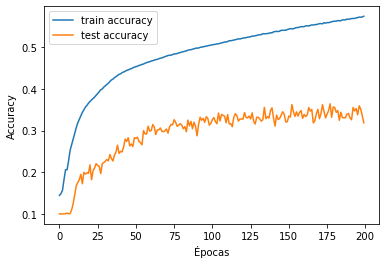

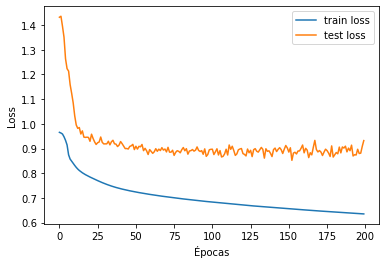

In [18]:
# ahora tengo los datos train_acc,train_loss,test_acc,test_loss
e = range(epocas)
plt.figure(1)
#train_acc y test_acc en funcion de epocas
plt.plot(e,train_acc,label="train accuracy")
plt.plot(e,test_acc,label="test accuracy")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("ej5_sit2MSE_accepoch.pdf")
#train_loss y test_loss en funcion de epocas
plt.figure(2)
plt.plot(e,train_loss,label="train loss")
plt.plot(e,test_loss,label="test loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.savefig("ej5_sit2MSE_lossepoch.pdf")
print("test accuracy final: ",test_acc[-1])

In [19]:
#SOLUCION SITUACION 2 CON RELU Y SOFTMAX - TODAVIA NO HECHO
train_acc2,train_loss2,test_acc2,test_loss2 = fit2(x_train,yy_train,x_test,yy_test,100,10,loss_softmax,grad_softmax,100,epocas,5e-7,1e-7)

epoca:  0
train data:  2.2659985758313756 0.14113999999999993
train data:  2.993544653745633 0.1
epoca:  1
train data:  2.20393074621979 0.18290000000000017
train data:  2.4471383368322948 0.1241
epoca:  2
train data:  2.138947086462098 0.21617999999999996
train data:  2.410999512157394 0.1085
epoca:  3
train data:  2.093104495842786 0.2291999999999998
train data:  2.322109034377015 0.1194
epoca:  4
train data:  2.048672014789535 0.2537199999999999
train data:  2.3731100967978698 0.1481
epoca:  5
train data:  1.967895026437867 0.2703999999999999
train data:  2.23607556423751 0.1881
epoca:  6
train data:  1.8896245379929124 0.31536000000000036
train data:  2.216048645501075 0.2222
epoca:  7
train data:  1.8351731630239883 0.33286
train data:  2.297532336810807 0.216
epoca:  8
train data:  1.796340739993486 0.3495800000000002
train data:  2.2498718993807216 0.2225
epoca:  9
train data:  1.7652717436412946 0.36528
train data:  2.3228321476105505 0.2156
epoca:  10
train data:  1.7367233755

train data:  2.196448355918173 0.3421
epoca:  83
train data:  1.1330141024896954 0.6106599999999995
train data:  2.3286578846196613 0.3228
epoca:  84
train data:  1.1285209225576376 0.6130600000000006
train data:  2.2081380038969716 0.3498
epoca:  85
train data:  1.1243702377959843 0.6144400000000004
train data:  2.1676136349480823 0.3464
epoca:  86
train data:  1.1194691796968512 0.6166399999999996
train data:  2.2577310233091143 0.3269
epoca:  87
train data:  1.115162375085893 0.61806
train data:  2.136884061920039 0.3583
epoca:  88
train data:  1.1115460911328963 0.6194000000000001
train data:  2.062438336437027 0.3638
epoca:  89
train data:  1.1069550795821914 0.6200400000000003
train data:  2.1750364046154997 0.3495
epoca:  90
train data:  1.1020123744130048 0.6212199999999999
train data:  2.2949046311757617 0.3317
epoca:  91
train data:  1.097407209468921 0.6251999999999999
train data:  2.208649392193308 0.3502
epoca:  92
train data:  1.093557236741715 0.6239399999999997
train da

train data:  0.8253314871835171 0.7240599999999993
train data:  2.688086793642283 0.333
epoca:  166
train data:  0.8223577638932777 0.7247200000000005
train data:  2.5993432337699165 0.343
epoca:  167
train data:  0.8190477163479704 0.7281800000000004
train data:  2.431926374171261 0.3509
epoca:  168
train data:  0.8160765995435594 0.7275600000000003
train data:  2.6586237911544686 0.3366
epoca:  169
train data:  0.8126424237896578 0.7299999999999996
train data:  2.425081392729525 0.3656
epoca:  170
train data:  0.809194685859083 0.7293400000000014
train data:  2.617622223807112 0.3308
epoca:  171
train data:  0.8062433857792043 0.7322999999999994
train data:  2.915171057677298 0.3136
epoca:  172
train data:  0.8033296033223464 0.7334799999999997
train data:  2.5387477678895904 0.3501
epoca:  173
train data:  0.8006859035918784 0.7343
train data:  2.537256410715105 0.3503
epoca:  174
train data:  0.7973770907776343 0.7347800000000002
train data:  2.8313080361416114 0.3306
epoca:  175
t

test accuracy final:  0.3232


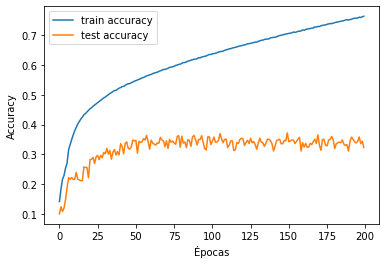

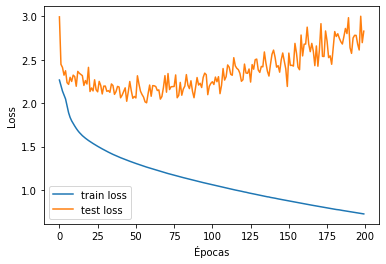

In [20]:
# ahora tengo los datos train_acc,train_loss,test_acc,test_loss
e = range(epocas)
plt.figure(1)
#train_acc y test_acc en funcion de epocas
plt.plot(e,train_acc2,label="train accuracy")
plt.plot(e,test_acc2,label="test accuracy")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("sit2SoftMax_accepoch.pdf")
#train_loss y test_loss en funcion de epocas
plt.figure(2)
plt.plot(e,train_loss2,label="train loss")
plt.plot(e,test_loss2,label="test loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.savefig("sit2SoftMax_lossepoch.pdf")
print("test accuracy final: ",test_acc2[-1])

In [21]:
#guardo datos por si tengo que comparar luego, por las dudas
np.savetxt('ej5sit2_mse.csv', (train_acc,train_loss,test_acc,test_loss), delimiter=',')
np.savetxt('ej5sit2_softmax.csv', (train_acc2,train_loss2,test_acc2,test_loss2), delimiter=',')

In [20]:
#SOLUCION SITUACION 1 CON RELU Y MSE
train_acc3,train_loss3,test_acc3,test_loss3 = fit1(x_train,yy_train,x_test,yy_test,100,10,MSE,grad_MSE,100,epocas,1e-6,1e-5)

epoca:  0
train data:  1.6586864402793038 0.1485399999999999
train data:  0.9994593135195249 0.1032
epoca:  1
train data:  0.9742047172571593 0.18348000000000023
train data:  0.999110853640973 0.1035
epoca:  2
train data:  0.9346322292237452 0.21798000000000017
train data:  0.992850696401306 0.1174
epoca:  3
train data:  0.9068382746319359 0.24843999999999997
train data:  0.9824978906086477 0.103
epoca:  4
train data:  0.8845525767398043 0.26712000000000014
train data:  0.9721909738175728 0.1167
epoca:  5
train data:  0.8645268837580828 0.2884199999999999
train data:  0.964053914226651 0.1392
epoca:  6
train data:  0.8446017061989974 0.3073600000000002
train data:  0.9531642191580779 0.1797
epoca:  7
train data:  0.8268661091553007 0.3272400000000003
train data:  0.944253225828296 0.2013
epoca:  8
train data:  0.8127740355791488 0.34034000000000053
train data:  0.9346605945664884 0.2083
epoca:  9
train data:  0.8018590728061389 0.35084000000000004
train data:  0.9229173701690552 0.2107

train data:  0.5924199691569337 0.5652200000000005
train data:  0.7908284567895383 0.3699
epoca:  83
train data:  0.5908195816552644 0.5663200000000004
train data:  0.7921386984981296 0.3642
epoca:  84
train data:  0.5893160833634704 0.5679000000000003
train data:  0.7995049340370591 0.3605
epoca:  85
train data:  0.5879464124234661 0.5686999999999999
train data:  0.7897498855065269 0.371
epoca:  86
train data:  0.5864511504381054 0.5708800000000004
train data:  0.7937971808008023 0.3674
epoca:  87
train data:  0.5849500929836816 0.5724800000000004
train data:  0.7864775250101028 0.3843
epoca:  88
train data:  0.5835027975909393 0.5731800000000004
train data:  0.8070553155026063 0.3524
epoca:  89
train data:  0.5821599843816468 0.5749800000000007
train data:  0.7918544977147877 0.366
epoca:  90
train data:  0.5807749981171575 0.5764000000000007
train data:  0.7991536152135218 0.3624
epoca:  91
train data:  0.5793691311002429 0.5780400000000006
train data:  0.7910940876429574 0.3707
epo

train data:  0.7925963011779038 0.3816
epoca:  164
train data:  0.4927923653936844 0.6607
train data:  0.8037033521376721 0.3763
epoca:  165
train data:  0.4919614032779405 0.6613199999999994
train data:  0.7951477941664364 0.3799
epoca:  166
train data:  0.4908808665720923 0.6621599999999997
train data:  0.793894376294463 0.3811
epoca:  167
train data:  0.48966790230363977 0.6632199999999996
train data:  0.791832191168205 0.3856
epoca:  168
train data:  0.4888500678769435 0.6642799999999998
train data:  0.8180478155311622 0.3679
epoca:  169
train data:  0.48804680994399535 0.6645199999999992
train data:  0.8026276135055019 0.3794
epoca:  170
train data:  0.48700464799235876 0.6645399999999996
train data:  0.7946677677320005 0.385
epoca:  171
train data:  0.4856398491937123 0.6651999999999996
train data:  0.8019012505108661 0.3806
epoca:  172
train data:  0.4847789021626627 0.6671400000000003
train data:  0.8036413657401386 0.3773
epoca:  173
train data:  0.4837670538122639 0.668179999

test accuracy final:  0.3653


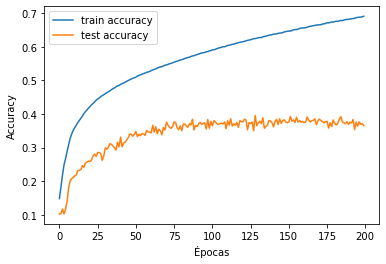

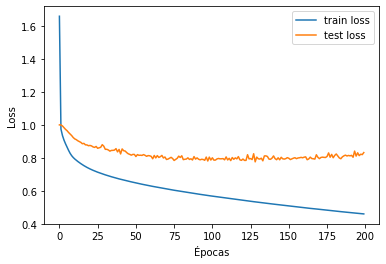

In [21]:
e = range(epocas)
plt.figure(1)
#train_acc y test_acc en funcion de epocas
plt.plot(e,train_acc3,label="train accuracy")
plt.plot(e,test_acc3,label="test accuracy")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("sit1MSE_accepoch.pdf")
#train_loss y test_loss en funcion de epocas
plt.figure(2)
plt.plot(e,train_loss3,label="train loss")
plt.plot(e,test_loss3,label="test loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.savefig("sit1MSE_lossepoch.pdf")
print("test accuracy final: ",test_acc3[-1])

In [25]:
#SOLUCION SITUACION 1 CON RELU Y SOFTMAX
train_acc4,train_loss4,test_acc4,test_loss4 = fit1(x_train,yy_train,x_test,yy_test,100,10,loss_softmax,grad_softmax,100,epocas,1e-5,1e-6)

epoca:  0
train data:  2.231733605027529 0.1774999999999999
train data:  2.2488211659166186 0.1024
epoca:  1
train data:  2.142047326591538 0.24126000000000003
train data:  2.235195941779304 0.1515
epoca:  2
train data:  2.053968542704877 0.2994999999999999
train data:  2.1619861664296813 0.2145
epoca:  3
train data:  2.011759039841487 0.33102000000000004
train data:  2.1544836752538528 0.2018
epoca:  4
train data:  1.985608291110693 0.35748000000000035
train data:  2.183349032674272 0.1898
epoca:  5
train data:  1.96559289598545 0.37364000000000014
train data:  2.1322263031011586 0.219
epoca:  6
train data:  1.9506816151398854 0.3859000000000002
train data:  2.1367444852318433 0.2028
epoca:  7
train data:  1.9398925533817901 0.39788000000000007
train data:  2.1232796430806156 0.2165
epoca:  8
train data:  1.9308776243739985 0.40535999999999933
train data:  2.1277875116980467 0.2187
epoca:  9
train data:  1.9227511717440546 0.4147600000000001
train data:  2.09762564803967 0.2215
epoca:

train data:  2.0615511362912486 0.3291
epoca:  83
train data:  1.73891701909389 0.5627400000000008
train data:  2.0595258920556723 0.3253
epoca:  84
train data:  1.7383044578858047 0.5623200000000003
train data:  2.055227651597104 0.3405
epoca:  85
train data:  1.7367956965508973 0.5634200000000006
train data:  2.0544797319141144 0.3296
epoca:  86
train data:  1.7359424681518878 0.5658200000000007
train data:  2.0443219327354654 0.3395
epoca:  87
train data:  1.7347928843944993 0.5660600000000003
train data:  2.050980047519955 0.3413
epoca:  88
train data:  1.7341162747380037 0.5669399999999998
train data:  2.0471262406032324 0.3452
epoca:  89
train data:  1.7327362003583475 0.5667800000000005
train data:  2.059317479037949 0.3384
epoca:  90
train data:  1.7317290927698292 0.5671000000000004
train data:  2.063408496316745 0.3297
epoca:  91
train data:  1.7310439106313584 0.568740000000001
train data:  2.0586286403882967 0.3281
epoca:  92
train data:  1.7301249086336805 0.56856000000000

train data:  1.6829505450881297 0.6022800000000005
train data:  2.0724592418725445 0.328
epoca:  165
train data:  1.68243554194396 0.6042799999999997
train data:  2.0778126046389707 0.3304
epoca:  166
train data:  1.6820161608983968 0.6043999999999999
train data:  2.086010851038565 0.3096
epoca:  167
train data:  1.6814172932100295 0.6041800000000003
train data:  2.068656557562172 0.3388
epoca:  168
train data:  1.6810488795902097 0.6037800000000002
train data:  2.0822922320259614 0.315
epoca:  169
train data:  1.6807962837351609 0.60534
train data:  2.082063685914013 0.3088
epoca:  170
train data:  1.6803950349716694 0.6053400000000002
train data:  2.083574669257789 0.3164
epoca:  171
train data:  1.6799765318098934 0.6053400000000003
train data:  2.0725763853842225 0.3279
epoca:  172
train data:  1.679997599006574 0.6048800000000005
train data:  2.072177706441141 0.3384
epoca:  173
train data:  1.6790144400711584 0.6063199999999997
train data:  2.079643398149205 0.3278
epoca:  174
tr

test accuracy final:  0.3429


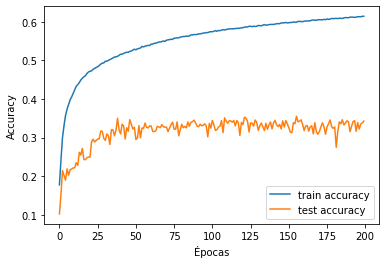

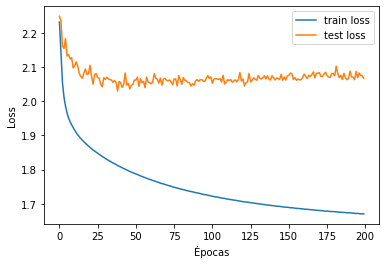

In [26]:
e = range(epocas)
plt.figure(1)
#train_acc y test_acc en funcion de epocas
plt.plot(e,train_acc4,label="train accuracy")
plt.plot(e,test_acc4,label="test accuracy")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("sit1SoftMax_accepoch.pdf")
#train_loss y test_loss en funcion de epocas
plt.figure(2)
plt.plot(e,train_loss4,label="train loss")
plt.plot(e,test_loss4,label="test loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.savefig("sit1SoftMax_lossepoch.pdf")
print("test accuracy final: ",test_acc4[-1])

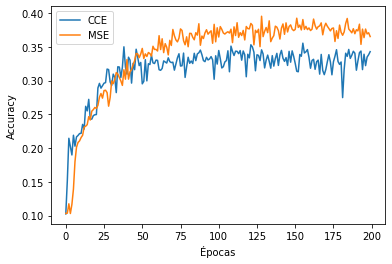

In [27]:
#grafico la comparacion entre ambos valores
plt.plot(e,test_acc4,label='CCE')
plt.plot(e,test_acc3,label='MSE')
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('ej5_comparacion_sit1.pdf')